In [8]:
import numpy as np
import pandas as pd
import pygad
import matplotlib.pyplot as plt


In [2]:
# FUNCTION TO READ THE DATA
import json

def parse(path):
    with open(path) as f:
        data = json.load(f)
        preferences = np.array(data["preferences"])
        friendships = np.array(data["friendships"])
        authorship = np.array(data["authorship"])

        # giving the info as a dictionary
        return {
            "num_papers": data["num_papers"],
            "num_reviewers": data["num_reviewers"],
            "reviewer_capacity": data["reviewer_capacity"],
            "min_reviews_per_paper": data["min_reviews_per_paper"],
            "max_reviews_per_paper": data["max_reviews_per_paper"],
            "preferences": preferences,
            "friendships": friendships,
            "authorship": authorship
        }
#reading the data        
data = parse("easy_dataset_1.json")

#saving the data in variables
num_papers = data["num_papers"]
num_reviewers = data["num_reviewers"]
reviewer_capacity = data["reviewer_capacity"]
min_reviews_per_paper = data["min_reviews_per_paper"]
max_reviews_per_paper = data["max_reviews_per_paper"],
preferences = data["preferences"]
friendships = data["friendships"]
authorship = data["authorship"] 

preferences

array([[3, 2, 1, 5, 3],
       [5, 2, 4, 2, 2],
       [4, 3, 1, 2, 4],
       [4, 2, 2, 1, 1],
       [4, 3, 4, 1, 5]])

In [3]:
# parameters of the genetic algorithm
generation_size = 10
number_of_generations = 10

# representation of the solutions
representation_solutions = np.empty([number_of_generations, generation_size , num_reviewers, num_papers])

In [4]:
# fittness function

# TODO gene_type of GA has to be a matrix with only 0 and 1

def fitness_function(ga_instance, solution, solution_idx):
    solution_matrix = solution.reshape((num_reviewers, num_papers))
    return compute_preference_value(solution_matrix) - compute_penalty(solution_matrix)

def compute_preference_value(solution):
    pref_val = 0

    for reviewer in range(solution.shape[0]):
        for paper in range(solution.shape[1]):
            if solution[reviewer, paper] == 1:
                pref_val = pref_val + preferences[reviewer, paper]

    return pref_val

def compute_penalty(solution):

    penalty = 0

    # penalty for reviewer capacity
    for reviewer in range(solution.shape[0]):
        if np.sum(solution[reviewer, :]) > reviewer_capacity:
            penalty += 1

    #penalty for the number of reviews in a paper
    for paper in range(solution.shape[1]):
        if np.sum(solution[:, paper]) > min_reviews_per_paper:
            penalty += 1
        elif np.sum(solution[:, paper]) > max_reviews_per_paper:
            penalty += 1

    #penalty for friendship using matricial operations
    for reviewer1 in range(solution.shape[0]):
        for reviewer2 in range(solution.shape[0]):
            if friendships[reviewer1,reviewer2] == 1: #they are friends
                for paper in range(solution.shape[1]):
                    if (solution[reviewer1,paper] == 1) and (solution[reviewer2,paper] == 1): #check if they review the same paper
                        penalty += 5

    #penalty for authory
    for reviewer in range(solution.shape[0]):
        for paper in range(solution.shape[1]):
            if solution[reviewer,paper] == 1 and (authorship[reviewer, paper]==1):
                penalty += 5

    return penalty

In [5]:
#try the function
solution = np.random.randint(2, size=(num_reviewers, num_papers))

print("Solution:")
print(solution)
print("Penalty: ",compute_penalty(solution))

Solution:
[[0 0 1 1 1]
 [1 1 0 1 0]
 [0 1 1 0 0]
 [1 1 0 0 1]
 [0 0 0 0 0]]
Penalty:  30


In [6]:
#First GA
ga_instance = pygad.GA(fitness_func = fitness_function,
                       num_generations = 50,
                       num_parents_mating = 5,
                       num_genes = num_reviewers * num_papers,
                       gene_space = [0,1],
                       sol_per_pop = 10
                       )
ga_instance.run()

solution, solution_fitness,  solution_idx = ga_instance.best_solution()
solution_matrix = solution.reshape((num_reviewers, num_papers))
print("Best solution: ")
print(solution_matrix)
print("Best fitness: ", solution_fitness)

Best solution: 
[[1. 0. 1. 1. 1.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0.]
 [1. 1. 0. 0. 1.]]
Best fitness:  37


c:\Users\Usuario\anaconda3\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


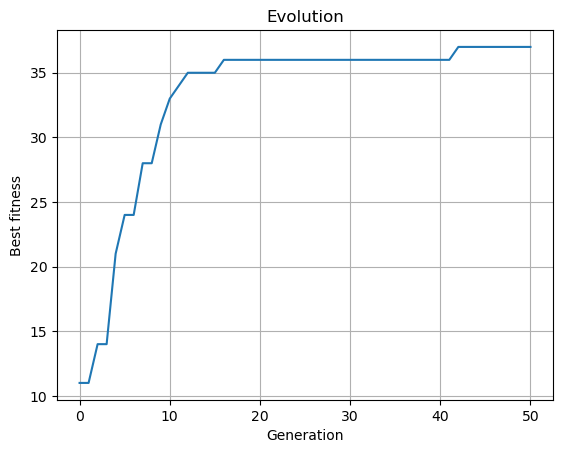

In [11]:
# Obtener la mejor fitness por generación
fitness_per_generation = ga_instance.best_solutions_fitness

plt.plot(fitness_per_generation)
plt.title("Evolution")
plt.xlabel("Generation")
plt.ylabel("Best fitness")
plt.grid()
plt.show()

In [91]:
#Crossover funtion
def custom_crossover(parents, child_size, ga_instance):
    child = np.empty(child_size)
    
    for i in range(child_size[0]):
        #select two parents randomly
        parent1 = i % parents.shape[0]
        parent2 = (i+1) % parents.shape[0]

        # crossing parents
        point = np.random.randint(1,parents.shape[1]-1)
        child[i, :point] = parents[parent1, :point]
        child[i,point:] = parents[parent2, point:]

    #validate the crossover solution
    for i in range(child_size[0]):
        child[i] = validate_solution(child[i])

    return child

#function to validate the crossover
def validate_solution(solution):
    solution_matrix = solution.reshape((num_reviewers, num_papers))
    
    # Making sure we don't exceed max_reviewers
    for paper in range(solution_matrix.shape[1]):
        if np.sum(solution_matrix[:, paper]) > max_reviews_per_paper:
            solution_matrix[:, paper] = 0  

    return solution_matrix.flatten()


In [92]:
#GA with custom crossover
ga_instance = pygad.GA(fitness_func = fitness_function,
                       num_generations = 50,
                       num_parents_mating = 5,
                       num_genes = num_reviewers * num_papers,
                       gene_space = [0,1],
                       sol_per_pop = 10,
                       crossover_type = custom_crossover
                       )
ga_instance.run()

solution, solution_fitness,  solution_idx = ga_instance.best_solution()
solution_matrix = solution.reshape((num_reviewers, num_papers))
print("Best solution: ")
print(solution_matrix)
print("Best fitness: ", solution_fitness)


Best solution: 
[[1. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 1. 1.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1.]]
Best fitness:  41


In [93]:
#Mutation function

def custom_mutation(solution, ga_instance):
    custom_rate = 0.2
    
    for i in range(len(solution)):
        if np.random.rand() < custom_rate:
            solution[i] = 1 - solution[i] #change 0 to 1 or 1 to 0

    #validate the mutation solution
    for k in range(len(solution)):
        solution[k] = validate_solution(solution[k])

    return solution

In [94]:
#GA with custom crossover and mutation
ga_instance = pygad.GA(fitness_func = fitness_function,
                       num_generations = 50,
                       num_parents_mating = 6,
                       num_genes = num_reviewers * num_papers,
                       gene_space = [0,1],
                       sol_per_pop = 14,
                       crossover_type=custom_crossover,
                       mutation_type = custom_mutation,                       
                    )
ga_instance.run()

solution, solution_fitness,  solution_idx = ga_instance.best_solution()
solution_matrix = solution.reshape((num_reviewers, num_papers))
print("Best solution: ")
print(solution_matrix)
print("Best fitness: ", solution_fitness)

Best solution: 
[[1. 1. 0. 1. 1.]
 [0. 0. 1. 1. 0.]
 [1. 1. 0. 0. 1.]
 [1. 1. 0. 1. 0.]
 [1. 1. 0. 0. 1.]]
Best fitness:  36
